# Spatial Structure of Phoenix and ICEWS #

This is the code that cleans, organizes, and creates measures of spatial structure for Phoenix and Icews data comparison. This will use Python 3.6 as comes with the Anaconda Library and includes additionally downloaded spatial data handing ilbraries such as:

pandas (data handling) 
pysal (spatial data) 
geopandas (a geographically focused version of pandas) 
matplotlib.pyplot (visualization and plotting) 
seaborn (visualization) 

Both Phoenix and ICEWS are event driven datasets. Event driven data differs from conventional survey or administratively based information in several ways. The core of their difference stems from proceudures used to collect them. Conventional survey data are collected for research purposes uses sampling techniques. Beause the data is collected with sampling a population as the main goal, there is built in distribution of values based on observations. Even driven data that is developed as both Phoenix and ICEWS derive from published news sources. Text from news sources is fed into a more or less complex process of Information Retrieval to extract sepecific aatributes associated with each news article.

In [58]:
import pandas as pd
import pysal as ps
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt
#import random
import numpy as np
import seaborn as sns
import math

In [2]:
pd.set_option('display.max_seq_items',None)
pd.set_option('display.max_columns',None)
pd.set_option('display.max_rows',None)

In [3]:
import matplotlib

matplotlib.rc('figure', figsize=(15, 20))

## ICEWS ##

In [4]:
icews08 = pd.read_csv('events.2008.20150313084156.tab',sep='\t')
icews09 = pd.read_csv('events.2009.20150313084349.tab',sep='\t') 
icews10 = pd.read_csv('events.2010.20150313084533.tab',sep='\t')
icews11 = pd.read_csv('events.2011.20150313084656.tab',sep='\t')


In [5]:
icews = pd.concat([icews08,icews09,icews10,icews11],axis=0)
irusgeo = icews.loc[(icews['Source Country'] == 'Russian Federation') & (icews['Target Country'] == 'Georgia'),:]
igeorus = icews.loc[(icews['Source Country'] == 'Georgia') & (icews['Target Country'] == 'Russian Federation'),:]
irg = pd.concat([irusgeo,igeorus],axis=0)
igeorg = irg.copy()



In [6]:
geometry = [Point(xy) for xy in zip(igeorg.Longitude,igeorg.Latitude)]
crs = {'init':'epsg:4326'}
igeorg = gpd.GeoDataFrame(igeorg, crs=crs, geometry=geometry)

In [7]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

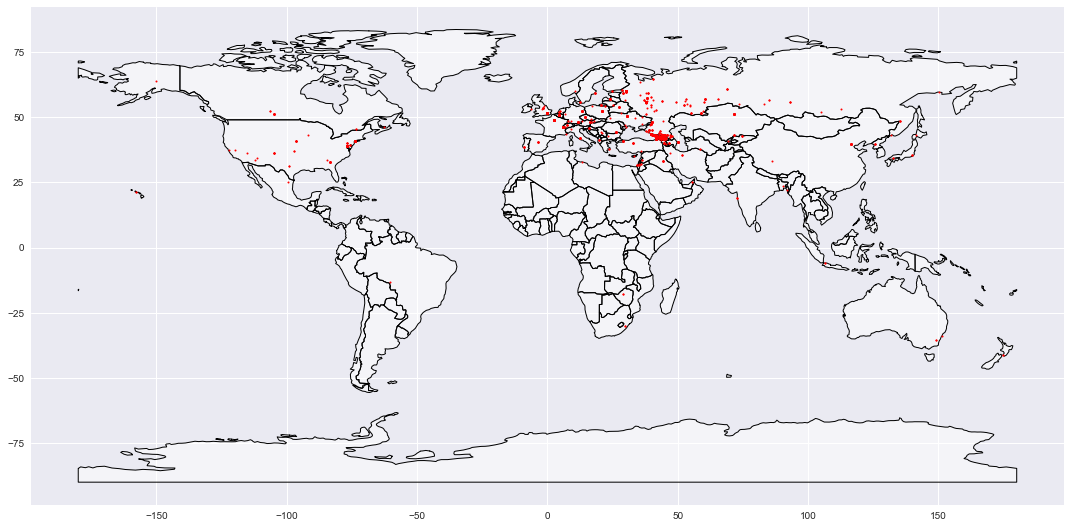

In [8]:
plt.clf()
fig,ax = plt.subplots()
ax.set_aspect('equal')
fig.set_size_inches(18.5, 10.5)
world.plot(ax=ax,color='white',edgecolor='black')
igeorg.plot(ax=ax,column='CAMEO Code',color='Red')
plt.show()

In [10]:
igeorgr = igeorg.loc[(igeorg['Longitude'] > 38) & (igeorg['Longitude'] < 55)]
igeorgr = igeorgr.loc[(igeorgr['Latitude'] > 40) & (igeorgr['Latitude'] < 45)]
print('Before filtering by coordinates ', igeorg.shape)
print('After filtering by coordinates ',  igeorgr.shape)

Before filtering by coordinates  (17049, 21)
After filtering by coordinates  (11132, 21)


In [11]:
igeorgr = igeorgr.drop_duplicates('Longitude')
igeorg1 = igeorgr.drop_duplicates('Latitude')
print('Removing duplicate values based on coordinates ', igeorg1.shape)

Removing duplicate values based on coordinates  (102, 21)


#### The above decision rule to remove by duplicates is a crude first pass at the data. 

In [12]:
iw = ps.weights.KNN.from_dataframe(igeorgr,k=3)
imi = ps.Moran(igeorgr['CAMEO Code'],iw)
ilm = ps.Moran_Local(igeorgr['CAMEO Code'],iw)

In [13]:
igeorgr['Is'] = ilm.Is
igeorgr['q'] = ilm.q
igeorgr['p_sim'] = ilm.p_sim
igeorgr['EI_sim'] = ilm.EI_sim

In [14]:
igeorgr.head()

,Event ID,Event Date,Source Name,Source Sectors,Source Country,Event Text,CAMEO Code,Intensity,Target Name,Target Sectors,Target Country,Story ID,Sentence Number,Publisher,City,District,Province,Country,Latitude,Longitude,geometry,Is,q,p_sim,EI_sim
8716,12562031,2008-01-05,Interfax,"Social,Media",Russian Federation,Discuss by telephone,41,1.0,Ministry (Georgia),Government,Georgia,8483847,3,BBC Monitoring Newsfile,Tbilisi,NaN,K'alak'i T'bilisi,Georgia,41.6941,44.8337,POINT (44.8337 41.6941),0.122595,3,0.341,0.002488
18096,12575169,2008-01-09,Russia,NaN,Russian Federation,Provide military protection or peacekeeping,74,8.5,Republic of South Ossetia,"Dissident,Separatists",Georgia,11512702,1,Russia & CIS General Newswire,South Ossetia,NaN,NaN,Georgia,42.3333,44.0000,POINT (44 42.3333),-0.020130,2,0.211,0.006655
44327,12616697,2008-01-18,Russia,NaN,Russian Federation,Criticize or denounce,111,-2.0,Mikhail Saakashvili,"Elite,Center Right,Ideological,Parties,(Nation...",Georgia,11117937,4,Dow Jones International News,Rustavi,NaN,NaN,Georgia,42.2897,43.8543,POINT (43.8543 42.2897),0.020943,3,0.483,0.004802
47770,12622867,2008-01-20,Sergey Viktorovich Lavrov,"Foreign Ministry,Center Right,Ideological,(Nat...",Russian Federation,Make a visit,42,1.9,Georgia,NaN,Georgia,10207596,1,BBC Monitoring Former Soviet Union,NaN,NaN,NaN,Georgia,42.0000,43.4999,POINT (43.4999 42),0.118929,3,0.351,0.006513
93817,12699338,2008-02-07,Russia,NaN,Russian Federation,Provide military protection or peacekeeping,74,8.5,Georgia,NaN,Georgia,9344805,6,ITAR Tass,Zugdidi,Zugdidis Raioni,Samegrelo-Zemo Svanetis Mkhare,Georgia,42.5088,41.8709,POINT (41.8709 42.5088),-0.752059,2,0.017,-0.000994


## Phoenix Data ##
I am using the data derived from the SWB () news sources because this is the only set from Phoenix that captures the Georgia-Russia conflict.

In [16]:
swb = pd.read_csv('PhoenixSWB_1979-2015.csv')

In [17]:
rusgeo = swb.loc[(swb['source_root'] == 'RUS') & (swb['target_root'] == 'GEO'),:]
georus = swb.loc[(swb['source_root'] == 'GEO') & (swb['target_root'] == 'RUS'),:]
rg = pd.concat([rusgeo,georus],axis=0) # Concatenating dataframe based on Russia and Georgia attributes.
print('The original dataset', rg.shape)

The original dataset (6216, 25)


In [18]:
geometry = [Point(xy) for xy in zip(rg.lon,rg.lat)]
crs = {'init':'epsg:4326'}
rg = gpd.GeoDataFrame(rg, crs=crs, geometry=geometry)

In [19]:
rg1 = rg.drop_duplicates('lon')
rg2 = rg1.drop_duplicates('lat')
print('After removing duplicates from Phoenix data set ', rg2.shape)
print(rg2.head())
print(type(rg2))

After removing duplicates from Phoenix data set  (163, 26)
              eid  story_date    year  month   day  source source_root  \
11057  SWB2535952  07/10/2009  2009.0    7.0  10.0  RUSGOV         RUS   
13349  SWB1184001  07/14/2009  2009.0    7.0  14.0  RUSPTY         RUS   
14151  SWB2355397  07/15/2009  2009.0    7.0  15.0     RUS         RUS   
16141  SWB1563901  07/20/2009  2009.0    7.0  20.0     RUS         RUS   
17897  SWB0390586  07/23/2009  2009.0    7.0  23.0  RUSMIL         RUS   

      source_agent source_others  target target_root target_agent  \
11057          GOV           NaN  GEOGOV         GEO          GOV   
13349          PTY           NaN     GEO         GEO          NaN   
14151          NaN           NaN     GEO         GEO          NaN   
16141          NaN           NaN     GEO         GEO          NaN   
17897          MIL           NaN  GEOPPL         GEO          NaN   

      target_others  code  root_code  quad_class  goldstein  \
11057           Na

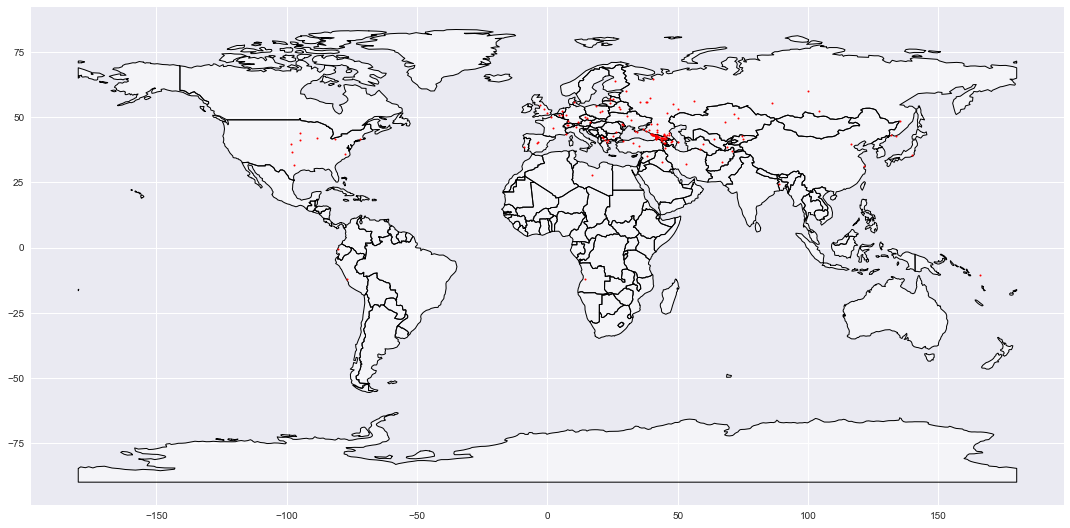

In [20]:
plt.clf()
figa,axa = plt.subplots()
axa.set_aspect('equal')
figa.set_size_inches(18.5, 10.5)
world.plot(ax=axa,color='white',edgecolor='black')
rg2.plot(ax=axa,column='goldstein',color='Red')
plt.show()

In [21]:
rg3 = rg2.loc[(rg2['lon'] > 38) & (rg2['lon'] < 55)]
rg4 = rg3.loc[(rg3['lat'] > 40) & (rg3['lat'] < 45)]
print('After filtering by coordinates ', rg4.shape)

After filtering by coordinates  (60, 26)


In [22]:
pw = ps.weights.KNN.from_dataframe(rg4,k=3)
pmi = ps.Moran(rg4['goldstein'],pw)
plm = ps.Moran_Local(rg4['goldstein'],pw)

In [23]:
rg5 = rg4.copy()
rg5['Is'] = plm.Is
rg5['q'] = plm.q
rg5['p_sim'] = plm.p_sim
rg5['EI_sim'] = plm.EI_sim

# Comparing Autocorrelation Values Between ICEWS and Phoenix with Filtering

In [248]:
igeorgr['data'] = 'icews'
#print(igeorgr.head())
rg5['data'] = 'phoenix'
#print(rg5.head())
rg5.rename(columns={'placename':'City'},inplace=True)
result1 = igeorgr.append(rg5)
print('Adding columns to merge between datasets')

Adding columns to merge between datasets


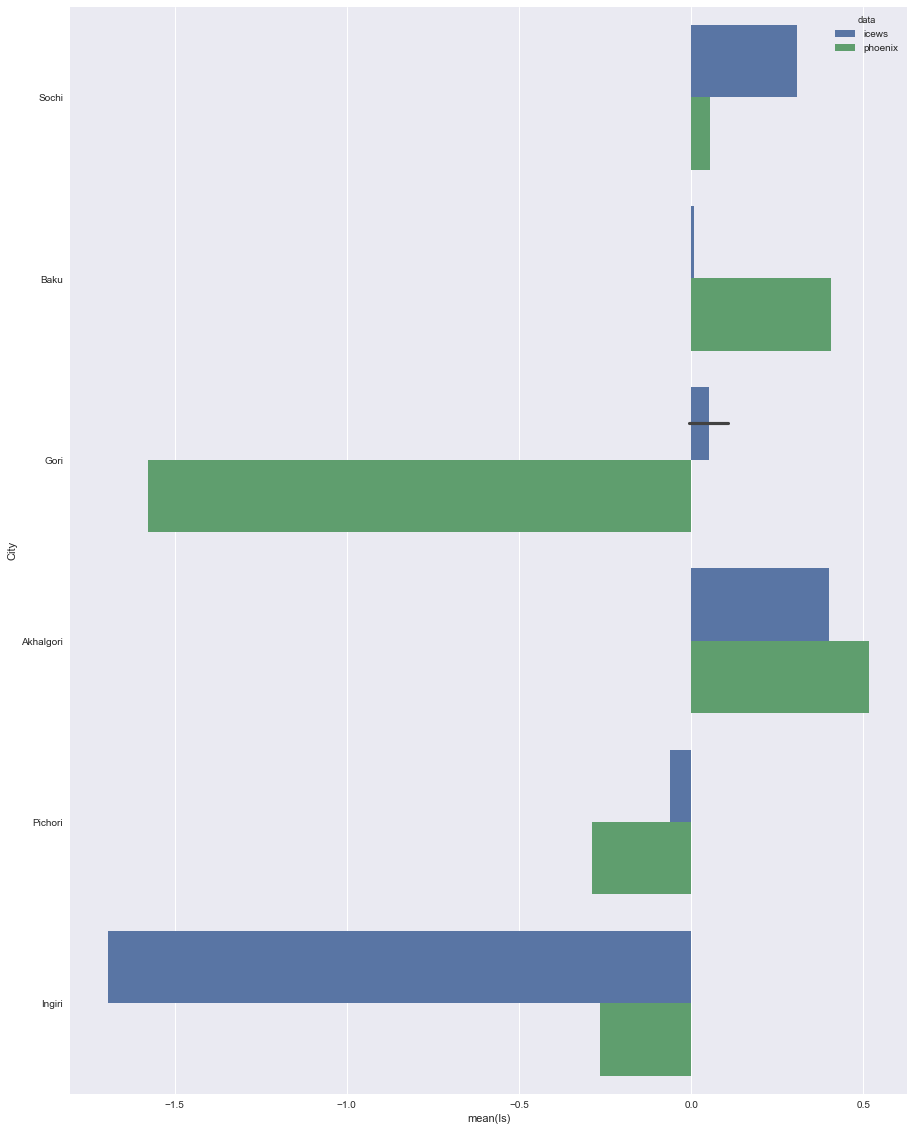

In [250]:
city_list = ['Akhalgori','Baku','Gori','Ingiri','Pichori','Sochi',
             'Tbilisa']
sub1 = result1.loc[result1['City'].isin(city_list)]
plt.clf()
sns.barplot(x='Is',y='City',data=sub1,hue='data')
#fig = matplotlib.pyplot.gcf()
#fig.set_size_inches(18.5, 10.5)
#plt.figure(figsize=(100,100))
plt.show()

## Spatial Stationarity 

In [253]:
print(sub1.loc[sub1['p_sim'] <= 0.05].shape)
print(sub1.loc[sub1['p_sim'] <= 0.05])

(4, 50)
         CAMEO Code       City  Country District    EI_sim  Event Date  \
641899        192.0  Akhalgori  Georgia      NaN  0.002667  2008-08-21   
190161          NaN       Gori      NaN      NaN  0.007566         NaN   
1387788         NaN       Baku      NaN      NaN -0.001625         NaN   
2762330         NaN    Pichori      NaN      NaN -0.008170         NaN   

           Event ID        Event Text  Intensity        Is  Latitude  \
641899   13541282.0  Occupy territory       -9.5  0.400950    42.126   
190161          NaN               NaN        NaN -1.577161       NaN   
1387788         NaN               NaN        NaN  0.406535       NaN   
2762330         NaN               NaN        NaN -0.288396       NaN   

         Longitude           Province             Publisher  Sentence Number  \
641899     44.4833  Mtskheta-Mtianeti  Agence France-Presse              5.0   
190161         NaN                NaN                   NaN              NaN   
1387788        NaN  

# Issues specific to event data:
    
    Information Retrieval; geoparsing; 

# Geo clustering issues with event data

## ICEWS with Repeating Values

In [28]:
igeorgm = irg.copy()
print('These are the top 5 repeating values of Longitude in the ICEWS dataset')
print(igeorgm.Latitude.value_counts().head())

These are the top 5 repeating values of Longitude in the ICEWS dataset
42.3333    5214
55.7522    4478
41.6941    2745
43.0005    1322
43.0070     409
Name: Latitude, dtype: int64


In [241]:
temp = igeorgm.copy()

latrands = []
for i in temp['Latitude']:
	latrands.append(np.random.random_sample((1,))-0.5)

latr = []
for i,j in zip(temp['Latitude'],latrands):
    latr.append(i+(j/2))
igeorgm['Latituder'] = latr

longrands = []
for i in temp['Longitude']:
	longrands.append(np.random.random_sample((1,))-0.5)

longr = []
for i,j in zip(temp['Longitude'],longrands):
	longr.append(i+(j/2))
temp['Longituder'] = longr

temp['Longituder'] = temp['Longituder'].astype('float')
temp['Latituder'] = temp['Latituder'].astype('float')
temp.Latituder.value_counts().head()



42.941758    1
55.837793    1
41.866072    1
42.538453    1
55.530081    1
Name: Latituder, dtype: int64

In [245]:
geometry = [Point(xy) for xy in zip(temp.Longituder,temp.Latituder)]
crs = {'init':'epsg:4326'}
temp1 = gpd.GeoDataFrame(temp, crs=crs, geometry=geometry)
type(temp)

print(temp.shape)
temp2 = temp1.loc[(temp1['Longituder'] > 38) & (temp1['Longituder'] < 46.5)]
temp3 = temp2.loc[(temp2['Latituder'] > 41) & (temp2['Latituder'] < 43.6)]
type(temp3)
print(temp3.shape)

(17049, 25)
(11034, 25)


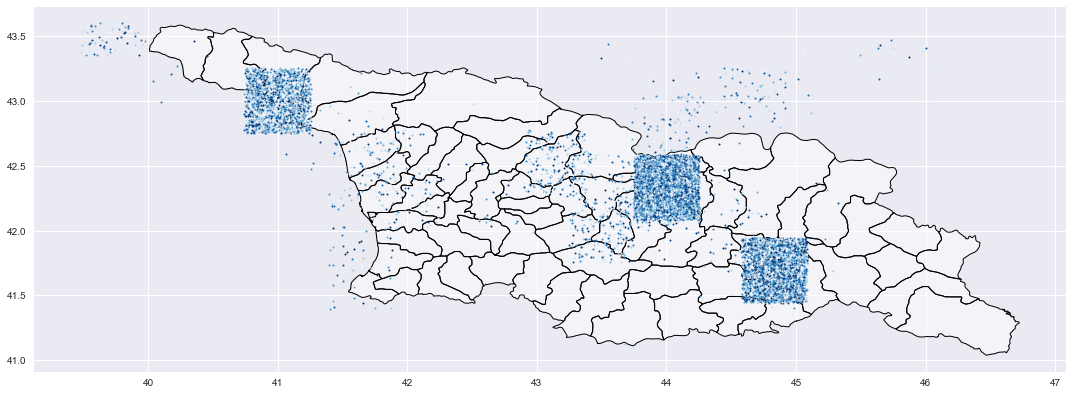

In [247]:
ga = gpd.read_file('GEO_adm2.shp')

plt.clf()
figt,axt = plt.subplots()
figt.set_size_inches(18.5, 10.5)
axt.set_aspect('equal')
ga.plot(ax=axt,color='white')
temp3.plot(ax=axt,cmap='Blues')
plt.show()

In [240]:
new_longr = []
new_latr = []

for i,j in zip(igeorgm['Longitude'],igeorgm['Latitude']):
    distance = 0.5
    random_longitude = 0
    random_latitude = 0
    while distance >= 0.4:
        random_longitude = (np.random.random_sample((1,))-(0.5))+i
        random_latitude = (np.random.random_sample((1,))-(0.5))+j
        distance = math.sqrt((random_latitude-j)**2+(random_longitude-i)**2)
    new_longr.append(random_longitude)
    new_latr.append(random_latitude)
                
igeorgm['longit'] = new_longr
igeorgm['latit'] = new_latr
     
#igeorgm['longit'] = igeorgm['longit'].astype('float')
#igeorgm['latit'] = igeorgm['latit'].astype('float')
igeorgm.latit.value_counts().head()



[51.6606823909]    1
[42.9226919544]    1
[42.6655885298]    1
[42.0344486933]    1
[55.9648635942]    1
Name: latit, dtype: int64

In [159]:
geometry = [Point(xy) for xy in zip(igeorgm.longit,igeorgm.latit)]
crs = {'init':'epsg:4326'}
igeorgm1 = gpd.GeoDataFrame(igeorgm, crs=crs, geometry=geometry)
type(igeorgm1)

geopandas.geodataframe.GeoDataFrame

In [160]:
print(igeorgm.shape)
igeorgm2 = igeorgm1.loc[(igeorgm1['longit'] > 38) & (igeorgm1['longit'] < 46.5)]
igeorgm3 = igeorgm2.loc[(igeorgm2['latit'] > 41) & (igeorgm2['latit'] < 43.6)]
type(igeorgm3)
print(igeorgm3.shape)

(17049, 25)
(11024, 25)


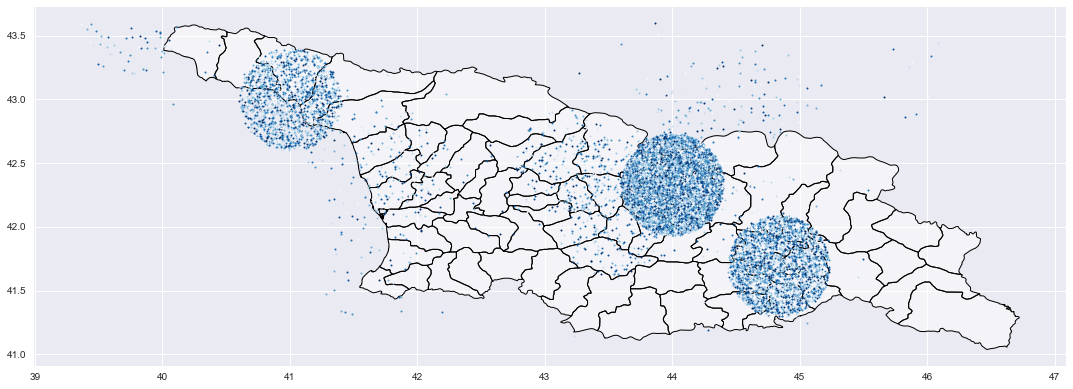

In [161]:
ga = gpd.read_file('GEO_adm2.shp')

plt.clf()
fig2,ax2 = plt.subplots()
fig2.set_size_inches(18.5, 10.5)
ax2.set_aspect('equal')
ga.plot(ax=ax2,color='white')
igeorgm3.plot(ax=ax2,cmap='Blues')
plt.show()


In [162]:
sorted_logit = igeorgm3.longit.sort_values()
old_val = None
new_val = None
min_val = 1
max_val = 0
for v in sorted_logit:
    old_val = new_val
    new_val = v
    if old_val == None or new_val == None:
        continue        
    diff = new_val - old_val
    if diff > max_val:
        max_val = diff
    if diff < min_val:
        min_val = diff
print(min_val,max_val)

[  8.02108246e-09] [ 0.2303869]


C:\Users\rxz155\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if __name__ == '__main__':


In [262]:
sub = igeorgm3.iloc[:5500,:]

In [263]:
m3w = ps.weights.KNN.from_dataframe(sub,k=3)
print(m3w.n)
print(igeorgm3.shape)
#m4mi = ps.Moran(igeorgm4['CAMEO Code'],m4w)
plm = ps.Moran_Local(sub['Intensity'],m3w)

5500
(11024, 25)


In [264]:
sub1 = sub.copy()
sub1['Is'] = plm.Is
sub1['q'] = plm.q
sub1['p_sim'] = plm.p_sim
sub1['EI_sim'] = plm.EI_sim

## Phoenix with Repeating Values

In [265]:
swbr = rg.copy()
print('The original dataset', rg.shape)
print(swbr.columns)

The original dataset (6216, 26)
Index(['eid', 'story_date', 'year', 'month', 'day', 'source', 'source_root',
       'source_agent', 'source_others', 'target', 'target_root',
       'target_agent', 'target_others', 'code', 'root_code', 'quad_class',
       'goldstein', 'joined_issues', 'lat', 'lon', 'placename', 'statename',
       'countryname', 'aid', 'process', 'geometry'],
      dtype='object')


In [194]:
new_longr = []
new_latr = []

for i,j in zip(swbr['lon'],swbr['lat']):
    distance = 0.5
    random_longitude = 0
    random_latitude = 0
    while distance >= 0.4:
        random_longitude = (np.random.random_sample((1,))-(0.5))+i
        random_latitude = (np.random.random_sample((1,))-(0.5))+j
        distance = math.sqrt((random_latitude-j)**2+(random_longitude-i)**2)
    new_longr.append(random_longitude)
    new_latr.append(random_latitude)
                
swbr['longer'] = new_longr
swbr['later'] = new_latr
     
#igeorgm['longit'] = igeorgm['longit'].astype('float')
#igeorgm['latit'] = igeorgm['latit'].astype('float')
swbr.later.value_counts().head()




[nan]              1
[55.7109161818]    1
[59.8440833632]    1
[nan]              1
[45.1910747189]    1
Name: later, dtype: int64

In [195]:
geometry = [Point(xy) for xy in zip(swbr.longer,swbr.later)]
crs = {'init':'epsg:4326'}
swbr1 = gpd.GeoDataFrame(swbr, crs=crs, geometry=geometry)
type(swbr1)

geopandas.geodataframe.GeoDataFrame

In [196]:
print(igeorgm.shape)
swbr2 = swbr1.loc[(swbr1['longer'] > 38) & (swbr1['longer'] < 46.5)]
swbr3 = swbr2.loc[(swbr2['later'] > 41) & (swbr2['later'] < 43.6)]
type(swbr3)
print(swbr3.shape)

(17049, 25)
(2051, 28)


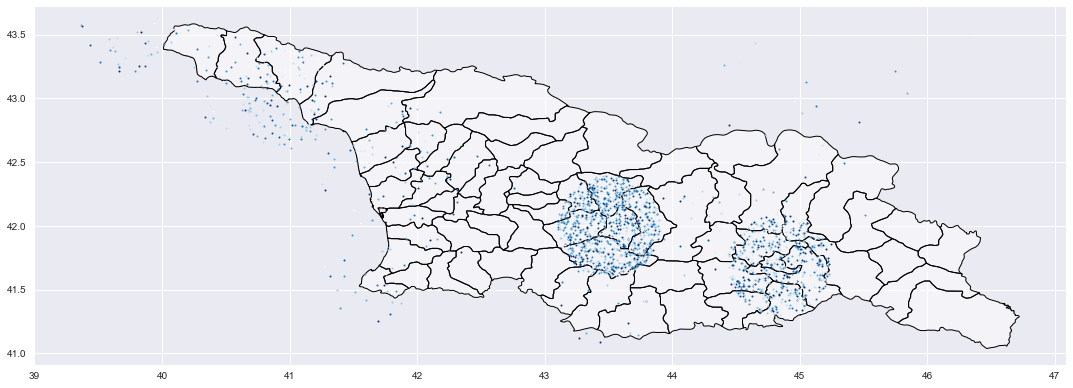

In [197]:
ga = gpd.read_file('GEO_adm2.shp')

plt.clf()
fig4,ax4 = plt.subplots()
fig4.set_size_inches(18.5, 10.5)
ax4.set_aspect('equal')
ga.plot(ax=ax4,color='white')
swbr3.plot(ax=ax4,cmap='Blues')
plt.show()

In [201]:
m3w = ps.weights.KNN.from_dataframe(swbr3,k=3)
print(m3w.n)
print(swbr3.shape)
#m4mi = ps.Moran(igeorgm4['CAMEO Code'],m4w)
plm = ps.Moran_Local(swbr3['goldstein'],m3w)

2051
(2051, 28)


In [203]:
swbr4 = swbr3.copy()
swbr4['Is'] = plm.Is
swbr4['q'] = plm.q
swbr4['p_sim'] = plm.p_sim
swbr4['EI_sim'] = plm.EI_sim

In [266]:
sub1['data'] = 'icews'
swbr4['data'] = 'phoenix'
swbr4.rename(columns={'placename':'City','code':'Event Text'},inplace=True)
result = sub1.append(swbr4)
print('Adding columns to merge between datasets')
result.to_csv('temp_test010101.csv')

Adding columns to merge between datasets


In [288]:
result.loc[result['Event Text'] == 10, 'Event Text'] = 'Make statement'
result.loc[result['Event Text'] == 40, 'Event Text'] = 'Consult'
result.loc[result['Event Text'] == 51, 'Event Text'] = 'Praise or endorse'
result.loc[result['Event Text'] == 42, 'Event Text'] = 'Make a visit'
result.loc[result['Event Text'] == 111, 'Event Text'] = 'Criticize or denounce'
result.loc[result['Event Text'] == 30, 'Event Text'] = 'Consult'
result.loc[result['Event Text'] == 190, 'Event Text'] = 'Military or increase armed forces'
result.loc[result['Event Text'] == 'Military or increase armed forces', 'Event Text'] = 'Mobilize or increase armed forces'
result.loc[result['Event Text'] == 'Demonstrate military or police power', 'Event Text'] = 'Mobilize or increase armed forces'




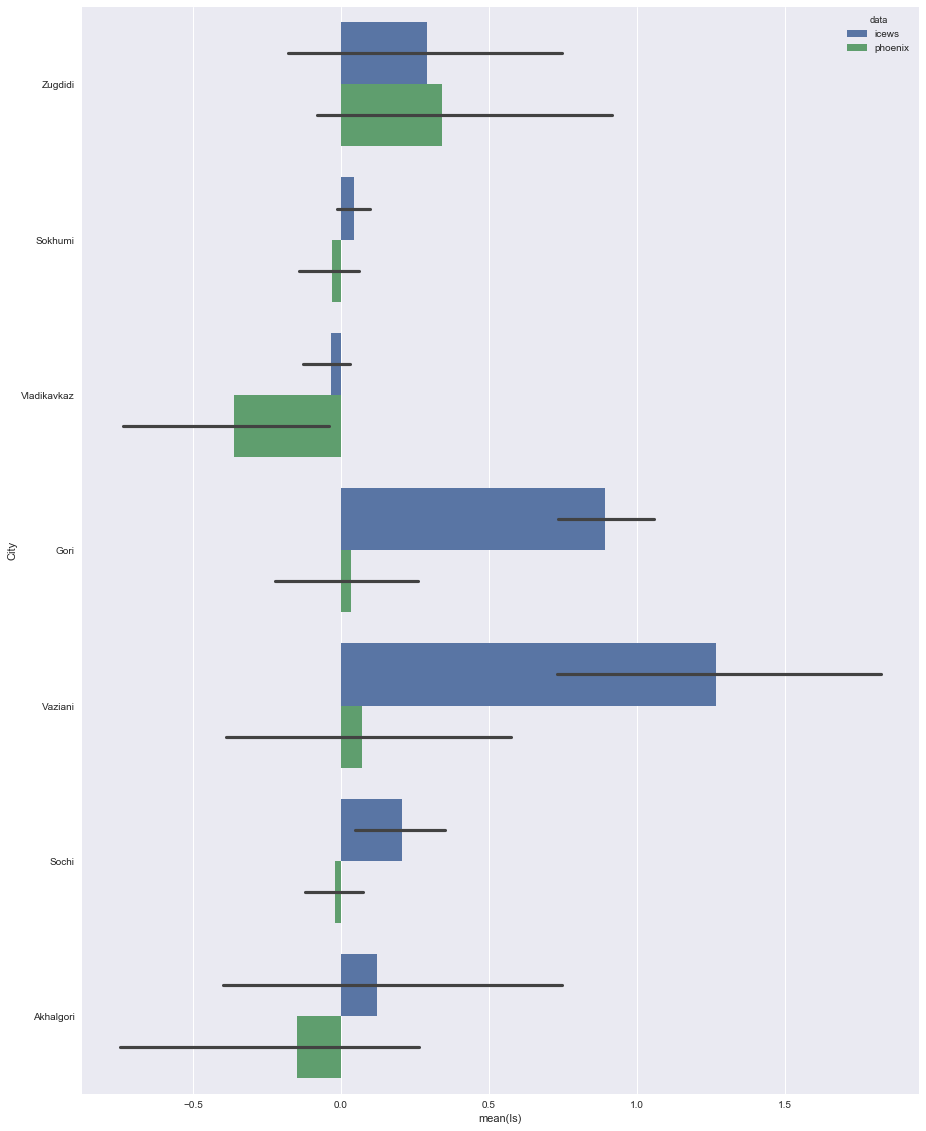

In [289]:
city_list = ['Akhalgori','Baku','Gori','Sokhumi','Vaziani','Sochi',
             'Tbilisa','Vladikavkaz','Zugdidi']
sub = result.loc[result['City'].isin(city_list)]
plt.clf()
sns.barplot(x='Is',y='City',data=sub,hue='data')
#fig = matplotlib.pyplot.gcf()
#fig.set_size_inches(18.5, 10.5)
#plt.figure(figsize=(100,100))
plt.show()

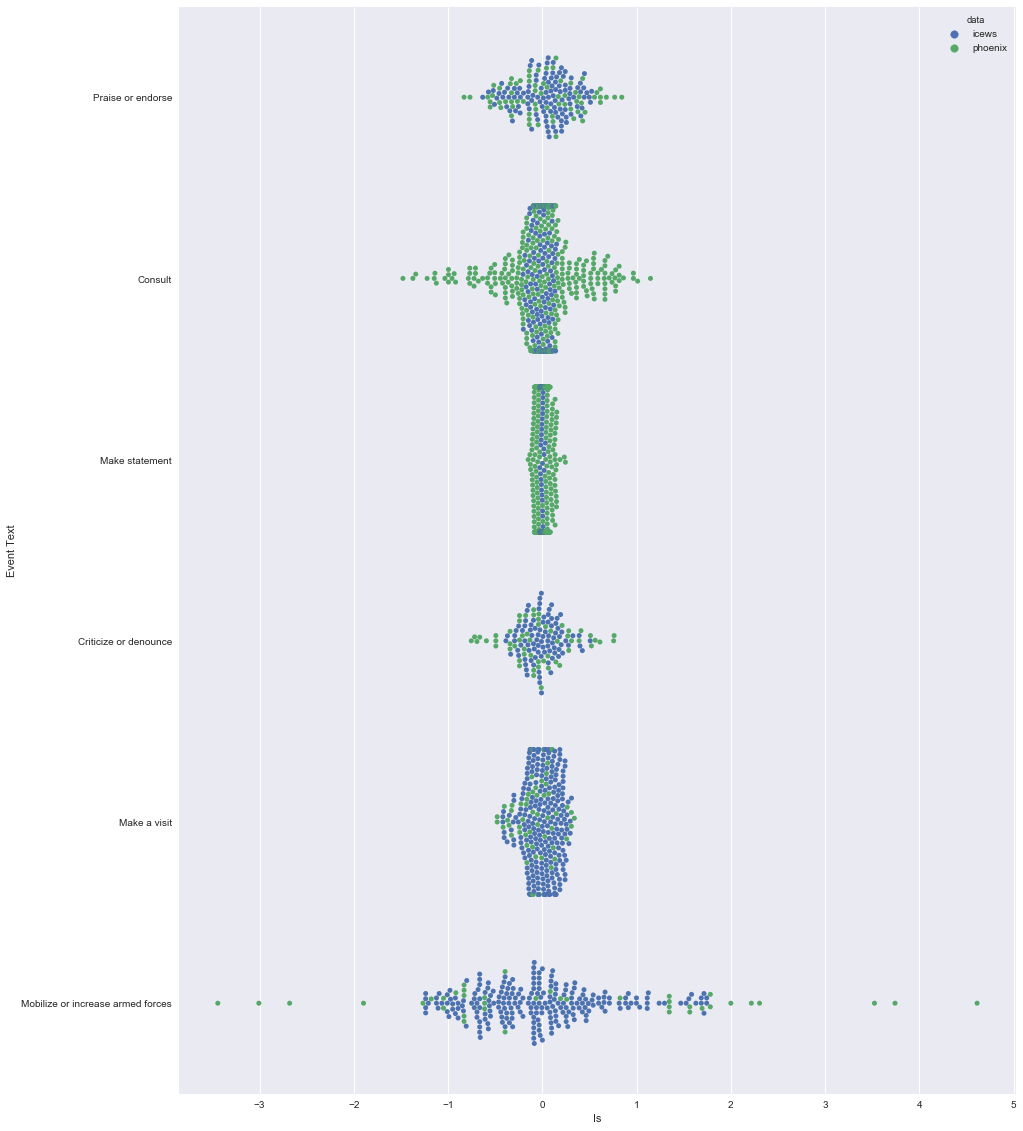

In [290]:
event_list = ['Make statement','Praise or endorse','Make a visit',
              'Criticize or denounce','Mobilize or increase armed forces','Consult']
sub = result.loc[result['Event Text'].isin(event_list)]
sns.swarmplot(x='Is',y='Event Text',hue='data',data=sub)
plt.show()

### Maybe it isn't useful to compare datasets accoding to city or just any event type but rather you need to think about the specifics about an event type and how it might be better or worse captured in the Information Retrieval processs. It looks like more serious and place specific events (criticize or denounce) are being captured similarly across the ICEWS and Phoenix datasets but that non-place specific events (verbal aggreement, praise or endorsement) are not being similarly captured. 

In [272]:
result.to_csv('testmilitary.csv')

## Spatial Non-Stationarity

In [270]:
print(sub.loc[sub['p_sim'] <= 0.05].shape)
sub.loc[sub['p_sim'] <= 0.05]

(161, 55)


,CAMEO Code,City,Country,District,EI_sim,Event Date,Event ID,Event Text,Intensity,Is,Latitude,Latituder,Longitude,Longituder,Province,Publisher,Sentence Number,Source Country,Source Name,Source Sectors,Story ID,Target Country,Target Name,Target Sectors,aid,countryname,data,day,eid,geometry,goldstein,joined_issues,lat,later,latit,lon,longer,longit,month,p_sim,process,q,quad_class,root_code,source,source_agent,source_others,source_root,statename,story_date,target,target_agent,target_others,target_root,year
34873,10.0,Tbilisi,Georgia,NaN,-0.000046,2008-01-15,12603173.0,Make statement,0.0,0.030175,41.6941,[41.8598205342],44.8337,[45.0475810713],K'alak'i T'bilisi,Russia & CIS General Newswire,3.0,Russian Federation,Dmitry Olegovich Rogozin,"Executive,Orthodox,Government,International Re...",8995629.0,Georgia,Mikhail Saakashvili,"Parties,Center Right,Ideological,Elite,(Nation...",NaN,NaN,icews,NaN,NaN,POINT (45.16363328730528 41.62934191015189),NaN,NaN,NaN,NaN,[41.6293419102],NaN,NaN,[45.1636332873],NaN,0.014,NaN,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
47466,51.0,South Ossetia,Georgia,NaN,0.011022,2008-01-20,12622550.0,Praise or endorse,3.4,0.472934,42.3333,[42.4205489968],44.0000,[44.1025671253],NaN,Xinhua News Agency,5.0,Russian Federation,Vladimir Putin,"Center Right,Ideological,Executive Office,(Nat...",10206364.0,Georgia,Mikhail Saakashvili,"Elite,Center Right,Ideological,Parties,(Nation...",NaN,NaN,icews,NaN,NaN,POINT (44.00041028923058 42.29106814970743),NaN,NaN,NaN,NaN,[42.2910681497],NaN,NaN,[44.0004102892],NaN,0.039,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
136905,51.0,Tbilisi,Georgia,NaN,-0.011393,2008-02-22,12765516.0,Praise or endorse,3.4,-0.570825,41.6941,[41.8266565911],44.8337,[44.716909802],K'alak'i T'bilisi,Prime-News (Georgia),1.0,Russian Federation,Russia,NaN,10186282.0,Georgia,Georgia,NaN,NaN,NaN,icews,NaN,NaN,POINT (44.96702813060026 41.52646912791157),NaN,NaN,NaN,NaN,[41.5264691279],NaN,NaN,[44.9670281306],NaN,0.023,NaN,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
179520,111.0,NaN,Georgia,NaN,-0.007931,2008-03-06,12831705.0,Criticize or denounce,-2.0,0.391689,42.0000,[42.238449543],43.4999,[43.3215429036],NaN,Agence France-Presse,2.0,Russian Federation,Russia,NaN,10543351.0,Georgia,Georgia,NaN,NaN,NaN,icews,NaN,NaN,POINT (43.17729919871194 42.19209556751785),NaN,NaN,NaN,NaN,[42.1920955675],NaN,NaN,[43.1772991987],NaN,0.020,NaN,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
217547,10.0,Tbilisi,Georgia,NaN,0.000149,2008-03-19,12891160.0,Make statement,0.0,0.029625,41.6941,[41.847114677],44.8337,[44.8778842192],K'alak'i T'bilisi,ITAR Tass,2.0,Russian Federation,Foreign Affairs (Russia),"Foreign Ministry,Executive,Government",12593892.0,Georgia,Georgia,NaN,NaN,NaN,icews,NaN,NaN,POINT (44.93324470599284 41.47886788953691),NaN,NaN,NaN,NaN,[41.4788678895],NaN,NaN,[44.933244706],NaN,0.021,NaN,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
311444,10.0,NaN,Georgia,NaN,0.000297,2008-04-22,13043588.0,Make statement,0.0,0.030395,43.0005,[43.2022522624],41.0050,[40.838019606],Abkhazia,Reuters News,2.0,Russian Federation,Foreign Affairs (Russia),"Government,Executive,Foreign Ministry",9029178.0,Georgia,Armed Separatist (Abkhazia),"Dissident,Separatists",NaN,NaN,icews,NaN,NaN,POINT (40.95320091068355 43.25614091352796),NaN,NaN,NaN,NaN,[43.2561409135],NaN,NaN,[40.9532009107],NaN,0.009,NaN,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
318251,51.0,South Ossetia,Georgia,NaN,-0.011748,2008-04-24,13052465.0,Praise or endorse,3.4,0.523849,42.3333,[42.3491066322],44.0000,[44.1900275992],NaN,Associated Press Newswires,3.0,Russian Federation,Russia,NaN,12300925.0,Georgia,Georgia,NaN,NaN,NaN,icews,NaN,NaN,POINT (43.87470445178095 42.33598414079279),NaN,NaN,NaN,NaN,[42.3359841408],NaN,NaN,[43.8747044518],NaN,0.021,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
339069,10.0,Tbilisi,Georgia,NaN,-0.000186,2008-05-02,13086336.0,Make statement,0.0,-0.019232,41.6941,[41.811

#### Because there are substantial clusters accross the whole profile of the country, I think a spatial regimes model may better fit the data than a Geographically Weighted Regression

In [282]:
result.loc[result['data'] == 'phoenix']['Event Text'].value_counts().head(20)

Make statement                       490
Consult                              209
30                                   198
112                                   79
20                                    68
Praise or endorse                     67
60                                    60
Make a visit                          56
Criticize or denounce                 55
110                                   46
44                                    44
173                                   40
Military or increase armed forces     39
171                                   38
80                                    36
57                                    36
50                                    34
16                                    33
100                                   30
170                                   28
120                                   23
130                                   23
140                                   19
43                                    19
12              